In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import check_random_state
from FFNN import FFNN


In [3]:
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

Sparsity with L1 penalty: 79.74%
Test score with L1 penalty: 0.8367
Example run in 11.035 s


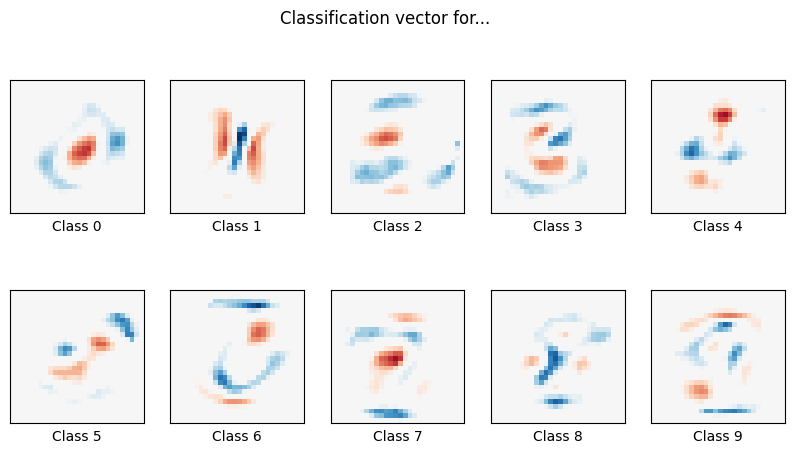

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

Epoch 1/20 - Train Loss: 0.8034 - Val Loss: 0.8046
Epoch 2/20 - Train Loss: 0.5271 - Val Loss: 0.5441
Epoch 3/20 - Train Loss: 0.3890 - Val Loss: 0.4172
Epoch 4/20 - Train Loss: 0.3234 - Val Loss: 0.3675
Epoch 5/20 - Train Loss: 0.2727 - Val Loss: 0.3247
Epoch 6/20 - Train Loss: 0.2309 - Val Loss: 0.3023
Epoch 7/20 - Train Loss: 0.2029 - Val Loss: 0.2845
Epoch 8/20 - Train Loss: 0.1839 - Val Loss: 0.2708
Epoch 9/20 - Train Loss: 0.1663 - Val Loss: 0.2737
Epoch 10/20 - Train Loss: 0.1482 - Val Loss: 0.2570
Epoch 11/20 - Train Loss: 0.1370 - Val Loss: 0.2541
Epoch 12/20 - Train Loss: 0.1255 - Val Loss: 0.2543
Epoch 13/20 - Train Loss: 0.1164 - Val Loss: 0.2424
Epoch 14/20 - Train Loss: 0.1056 - Val Loss: 0.2397
Epoch 15/20 - Train Loss: 0.0991 - Val Loss: 0.2449
Epoch 16/20 - Train Loss: 0.0911 - Val Loss: 0.2323
Epoch 17/20 - Train Loss: 0.0855 - Val Loss: 0.2349
Epoch 18/20 - Train Loss: 0.0818 - Val Loss: 0.2333
Epoch 19/20 - Train Loss: 0.0741 - Val Loss: 0.2296
Epoch 20/20 - Train L

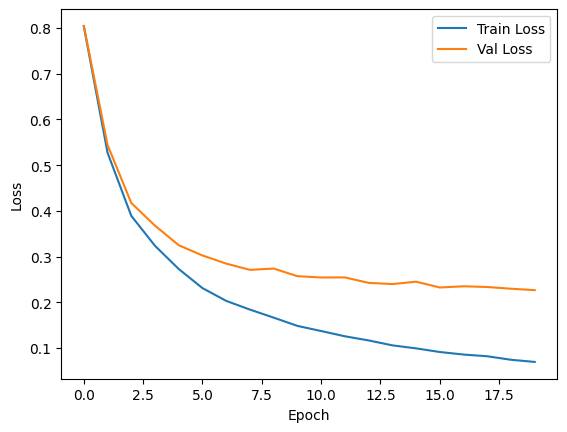

Iteration 1, loss = 1.09898664
Iteration 2, loss = 0.31945220
Iteration 3, loss = 0.18960170
Iteration 4, loss = 0.12337028
Iteration 5, loss = 0.08568866
Iteration 6, loss = 0.06325492
Iteration 7, loss = 0.04221004
Iteration 8, loss = 0.03029954
Iteration 9, loss = 0.02419324
Iteration 10, loss = 0.01767468
Iteration 11, loss = 0.01339305
Iteration 12, loss = 0.01052839
Iteration 13, loss = 0.00856200
Iteration 14, loss = 0.00701849
Iteration 15, loss = 0.00588401
Iteration 16, loss = 0.00512869
Iteration 17, loss = 0.00439272
Iteration 18, loss = 0.00382074
Iteration 19, loss = 0.00339395
Iteration 20, loss = 0.00301012


/home/archlinux/Desktop/Kuliah/ML/Tubes1/whitebox/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


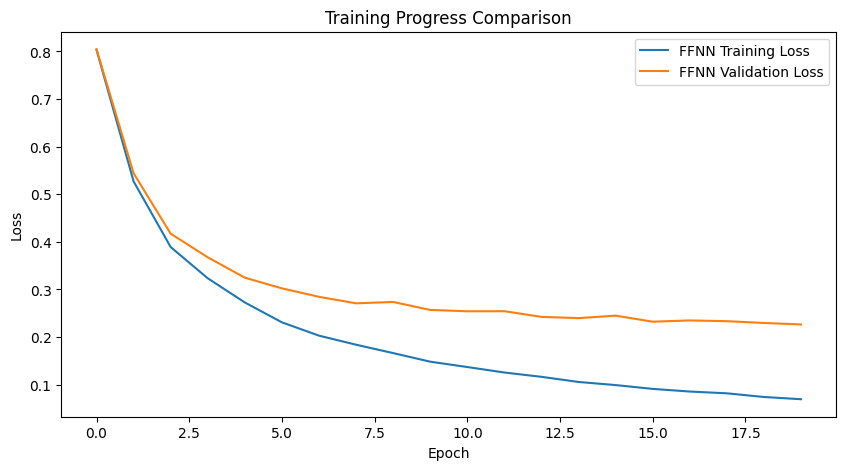

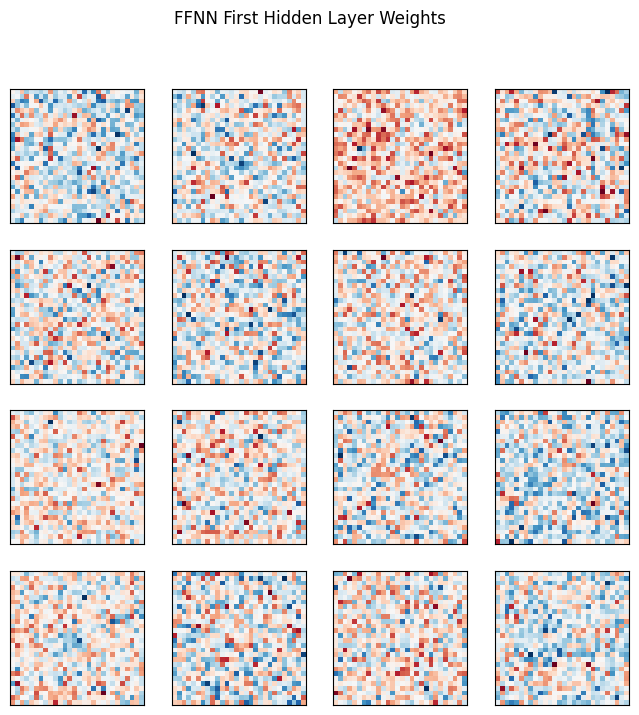


================= Hasil Perbandingan =================
FFNN Test Accuracy: 0.00% | Waktu: 5.38s
MLP Test Accuracy: 93.15% | Waktu: 5.50s


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)
# 3. Implementasi FFNN Kustom
# ==============================
layer_sizes = [784, 128, 64, 10]
activations = ['relu', 'relu', 'relu']
weight_inits = [
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42},
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42},
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42}
]

t0 = time.time()
ffnn_model = FFNN(
    layer_sizes=layer_sizes,
    activations=activations,
    loss_function='categorical_cross_entropy',
    weight_inits=weight_inits
)

# Konversi label ke one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))

# Training
history = ffnn_model.train(
    X_train=X_train,
    y_train=y_train_onehot,
    X_val=X_val,
    y_val=y_val_onehot,
    epochs=20,
    batch_size=128,
    learning_rate=0.0001,
    verbose=1
)

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluasi
test_pred = ffnn_model.forward(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
ffnn_accuracy = np.mean(test_pred_classes == y_test)
ffnn_time = time.time() - t0

# 4. Implementasi MLPClassifier
# ==============================
t0 = time.time()
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=128,
    max_iter=20,
    verbose=True,
    random_state=42
)

mlp_clf.fit(X_train, y_train)
mlp_accuracy = mlp_clf.score(X_test, y_test)
mlp_time = time.time() - t0

# 5. Plotting dan Hasil
# ==============================
# Plot akurasi
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='FFNN Training Loss')
plt.plot(history['val_loss'], label='FFNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress Comparison')
plt.legend()
plt.show()

# Plot bobot layer pertama
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    if i < ffnn_model.layers[0].W.shape[1]:
        ax.imshow(ffnn_model.layers[0].W[:, i].reshape(28, 28), cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
plt.suptitle("FFNN First Hidden Layer Weights")
plt.show()

# Print hasil
print("\n================= Hasil Perbandingan =================")
print(f"FFNN Test Accuracy: {ffnn_accuracy * 100:.2f}% | Waktu: {ffnn_time:.2f}s")
print(f"MLP Test Accuracy: {mlp_accuracy * 100:.2f}% | Waktu: {mlp_time:.2f}s")
print("=======================================================")

Epoch 1, Test Accuracy: 0.8631
Epoch 2, Test Accuracy: 0.8931
Epoch 3, Test Accuracy: 0.9068
Epoch 4, Test Accuracy: 0.9102
Epoch 5, Test Accuracy: 0.9153
Epoch 6, Test Accuracy: 0.9177
Epoch 7, Test Accuracy: 0.9171
Epoch 8, Test Accuracy: 0.9212
Epoch 9, Test Accuracy: 0.9216
Epoch 10, Test Accuracy: 0.9210
Epoch 11, Test Accuracy: 0.9206
Epoch 12, Test Accuracy: 0.9208
Epoch 13, Test Accuracy: 0.9209
Epoch 14, Test Accuracy: 0.9225
Epoch 15, Test Accuracy: 0.9226
Epoch 16, Test Accuracy: 0.9244
Epoch 17, Test Accuracy: 0.9247
Epoch 18, Test Accuracy: 0.9238
Epoch 19, Test Accuracy: 0.9249
Epoch 20, Test Accuracy: 0.9254


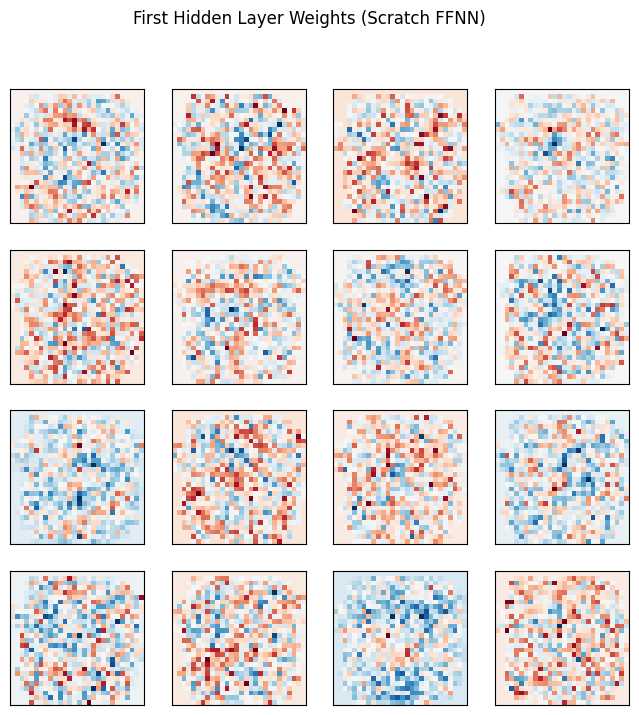

Test accuracy with scratch FFNN: 0.9254
Total run time: 85.787 s


In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def forward(X, W1, b1, W2, b2, W3, b3):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)
    return a3, (z1, a1, z2, a2, z3, a3)

def backward(X, y_true, params, cache):
    W1, b1, W2, b2, W3, b3 = params
    z1, a1, z2, a2, z3, a3 = cache
    batch_size = X.shape[0]
    
    dz3 = (a3 - y_true) / batch_size
    dW3 = np.dot(a2.T, dz3)
    db3 = np.sum(dz3, axis=0)
    
    dz2 = np.dot(dz3, W3.T) * (z2 > 0)
    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0)
    
    dz1 = np.dot(dz2, W2.T) * (z1 > 0)
    dW1 = np.dot(X.T, dz1)
    db1 = np.sum(dz1, axis=0)
    
    return dW1, db1, dW2, db2, dW3, db3

t0 = time.time()
train_samples = 5000

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000, shuffle=False
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train_onehot = np.eye(10)[y_train]
y_test_onehot = np.eye(10)[y_test]

np.random.seed(1)
input_size = 784
hidden1_size = 128
hidden2_size = 64
output_size = 10
alpha = 0.0001  # L2

W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2. / input_size)
b1 = np.zeros(hidden1_size)
W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2. / hidden1_size)
b2 = np.zeros(hidden2_size)
W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2. / hidden2_size)
b3 = np.zeros(output_size)

learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
t = 0

m_W1, v_W1 = np.zeros_like(W1), np.zeros_like(W1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_W2, v_W2 = np.zeros_like(W2), np.zeros_like(W2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_W3, v_W3 = np.zeros_like(W3), np.zeros_like(W3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)

epochs = 20
batch_size = 128

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train_onehot[permutation]
    
    for i in range(0, X_train.shape[0], batch_size):
        t += 1
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        
        # Forward
        a3, cache = forward(X_batch, W1, b1, W2, b2, W3, b3)
        loss = cross_entropy_loss(y_batch, a3)
        
        # Backward
        dW1, db1, dW2, db2, dW3, db3 = backward(X_batch, y_batch, (W1, b1, W2, b2, W3, b3), cache)
        
        dW1 += alpha * W1
        dW2 += alpha * W2
        dW3 += alpha * W3
        
        for param, delta in zip([m_W1, m_b1, m_W2, m_b2, m_W3, m_b3],
                                [dW1, db1, dW2, db2, dW3, db3]):
            param[...] = beta1 * param + (1 - beta1) * delta
        
        for param, delta in zip([v_W1, v_b1, v_W2, v_b2, v_W3, v_b3],
                                [dW1**2, db1**2, dW2**2, db2**2, dW3**2, db3**2]):
            param[...] = beta2 * param + (1 - beta2) * delta
        
        for weight, m, v in zip([W1, b1, W2, b2, W3, b3],
                                [m_W1, m_b1, m_W2, m_b2, m_W3, m_b3],
                                [v_W1, v_b1, v_W2, v_b2, v_W3, v_b3]):
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            weight -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    test_probs, _ = forward(X_test, W1, b1, W2, b2, W3, b3)
    test_preds = np.argmax(test_probs, axis=1)
    accuracy = np.mean(test_preds == y_test)
    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}")

# Plot

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    if i < W1.shape[1]:
        ax.imshow(W1[:, i].reshape(28, 28), cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
plt.suptitle("First Hidden Layer Weights (Scratch FFNN)")
plt.show()

# END OF Plot Code

score = accuracy
print(f"Test accuracy with scratch FFNN: {score:.4f}")
run_time = time.time() - t0
print(f"Total run time: {run_time:.3f} s")